In [1]:
import pandas as pd
import numpy as np
import healpy as hp
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from deepsphere import HealpyGCNN, healpy_layers as hp_layer
import matplotlib.pyplot as plt
import glob
import os
%matplotlib inline
print("GPUs visible to TF:", tf.config.list_physical_devices("GPU"))

leaflet_type = 'outer'
params = np.load("training_output/outer_radial_normalization_params.npz")
radial_mean = params['mean']
radial_std = params['std']
all_folders = [
    d for d in os.listdir(".")
    if d.startswith("configf_") and os.path.isdir(d)
]

with open("training_output/outer_test_folders.txt", "r") as f:
    test_folders = [line.strip() for line in f if line.strip()]
with open("training_output/outer_train_folders.txt", "r") as f:
    train_folders = [line.strip() for line in f if line.strip()]

print('all folders', len(all_folders), 'train folders', len(train_folders), 'test folders', len(test_folders))
print(all_folders[0:5], train_folders[:5], test_folders[:5])

2025-06-04 14:27:36.788062: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749040056.862589  108516 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749040056.901886  108516 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749040057.036061  108516 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749040057.036253  108516 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749040057.036258  108516 computation_placer.cc:177] computation placer alr

GPUs visible to TF: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
all folders 954 train folders 725 test folders 129
['configf_1377', 'configf_1797', 'configf_1157', 'configf_790', 'configf_2396'] ['configf_1966', 'configf_2866', 'configf_3389', 'configf_2407', 'configf_3877'] ['configf_2989', 'configf_577', 'configf_3568', 'configf_2808', 'configf_322']


In [2]:
outer_blocks = []
inner_blocks = []

def fill_and_shift(cluster_map):
    # cluster_map: floats, NaN where no lipid, 0/1/2 for cluster
    # we want: 0 → no lipid, 1→cluster0, 2→cluster1, 3→cluster2
    out = np.empty_like(cluster_map, dtype=np.float32)
    # first mark “no lipid”
    mask_nan = np.isnan(cluster_map)
    out[mask_nan] = 0.0
    # then shift the real clusters up by 1
    valid = ~mask_nan
    out[valid] = cluster_map[valid] + 1.0
    return out

for config in test_folders:
    path = os.path.join(config, 'analysis_output')

    # --- OUTER leaflet block (shape (4, x, y)) ---
    outer_radial = np.load(os.path.join(path, "area_outer_radial_dist.npy"))
    #print("radial NaNs?", np.isnan(outer_radial).any())
    outer_chol_uns = fill_and_shift(np.load(os.path.join(path, "nmfk_phase_map_OUTER_CHOL_vs_UNS.npy")))
    outer_sat_chol = fill_and_shift(np.load(os.path.join(path, "nmfk_phase_map_OUTER_SAT_vs_CHOL.npy")))
    outer_uns_sat = fill_and_shift(np.load(os.path.join(path, "nmfk_phase_map_OUTER_UNS_vs_SAT.npy")))

    outer_blocks.append([[outer_radial, outer_uns_sat, outer_sat_chol, outer_chol_uns]])

    # --- OUTER leaflet block (shape (4, x, y)) ---
    inner_radial = np.load(os.path.join(path, "area_inner_radial_dist.npy"))
    #print("radial NaNs?", np.isnan(inner_radial).any())
    inner_chol_uns = fill_and_shift(np.load(os.path.join(path, "nmfk_phase_map_INNER_CHOL_vs_UNS.npy")))
    inner_sat_chol = fill_and_shift(np.load(os.path.join(path, "nmfk_phase_map_INNER_SAT_vs_CHOL.npy")))
    inner_uns_sat = fill_and_shift(np.load(os.path.join(path, "nmfk_phase_map_INNER_UNS_vs_SAT.npy")))

    inner_blocks.append([inner_radial, inner_chol_uns, inner_sat_chol, inner_uns_sat])

outer_stacked = []
for block in outer_blocks:
    block = np.stack(block, axis=-1)
    #print(block.shape)
    block = np.swapaxes(block, 0, 3)
    block = np.squeeze(block)
    print(block.shape)
    outer_stacked.append(block)

stacked = np.concat(outer_stacked, axis=0)
#for i, frame in enumerate(stacked):
#    for j in range(4):
#        #print(frame[:,j].shape)
#        stacked[i,:,j] = hp.reorder(frame[:,j], r2n=True)



stacked.shape

(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(70, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(77, 3072, 4)
(101, 3072, 4)
(86, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(96, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)
(101, 3072, 4)

(12933, 3072, 4)

In [3]:
#TESTING FUNCTION!!!
#stacked = stacked[0:50]

num_total_samples = stacked.shape[0]
num_random_samples_to_select = 50

if num_total_samples >= num_random_samples_to_select:
    # Generate 50 unique random indices from the range [0, num_total_samples - 1]
    random_indices = np.random.choice(num_total_samples, num_random_samples_to_select, replace=False)
    
    # Select the samples at these random indices
    stacked = stacked[random_indices]

/tmp/ipykernel_35536/1987711407.py:27: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  recon = hp.alm2map(alm, nside=NSIDE, lmax=lmax, verbose=False)


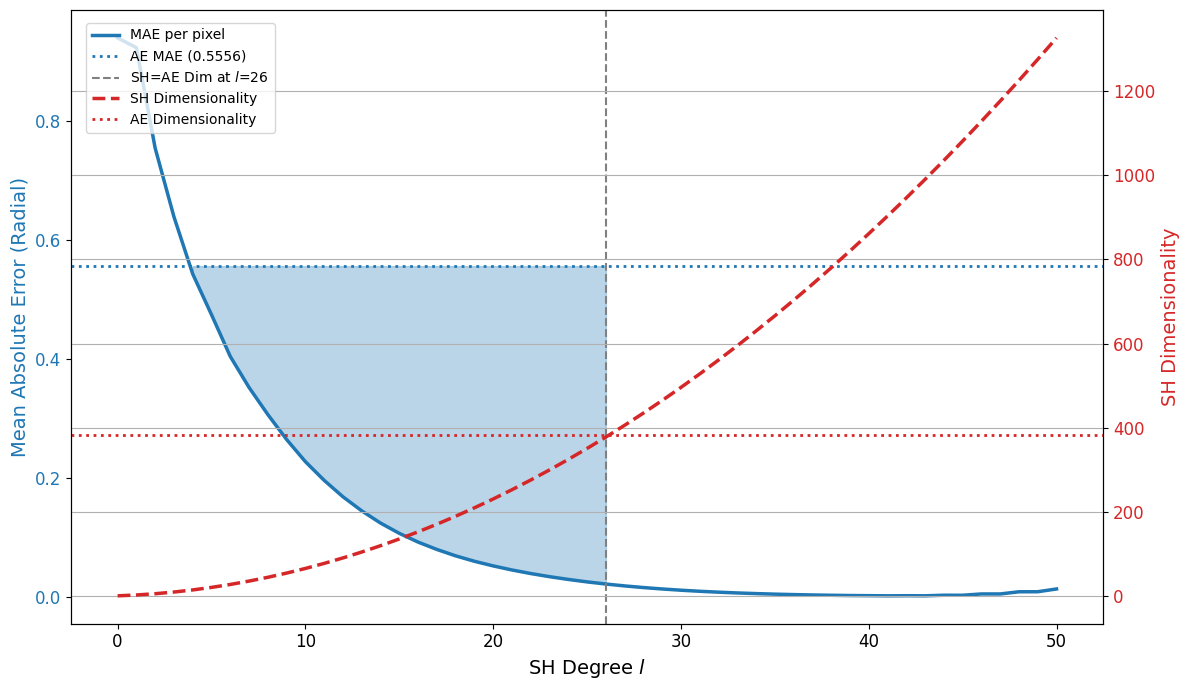

In [3]:
# ------------------- Healpy neighbor table -------------------
NSIDE = 16
N_PIX = hp.nside2npix(NSIDE)
n_samples = stacked.shape[0]


lmax_values = np.arange(0, 51)
target_dim = 384
ae_mae = 0.5556

mae_per_lmax = []
dims_per_lmax = []
used_lmax_values = []

for lmax in lmax_values:
    if lmax > 4 * NSIDE:  # Avoid HEALPix warning
        continue

    total_mae = 0.0
    total_batches = 0

    for idx in range(n_samples):
        sample = stacked[idx]  # shape: (3072, 4)
        radial_map = sample[:, 0]

        alm = hp.map2alm(radial_map, lmax=lmax)
        recon = hp.alm2map(alm, nside=NSIDE, lmax=lmax, verbose=False)

        mae = np.mean(np.abs(radial_map - recon))
        total_mae += mae
        total_batches += 1

    avg_mae = total_mae / total_batches
    mae_per_lmax.append(avg_mae)
    l_dimension = hp.Alm.getsize(lmax) 
    dims_per_lmax.append(l_dimension)
    used_lmax_values.append(lmax)

# Convert to numpy arrays
used_lmax_values = np.array(used_lmax_values)
mae_per_lmax = np.array(mae_per_lmax)
dims_per_lmax = np.array(dims_per_lmax)

# Find closest indices
idx_dim = np.argmin(np.abs(dims_per_lmax - target_dim))
idx_mae = np.argmin(np.abs(mae_per_lmax - ae_mae))

shade_start = min(idx_dim, idx_mae)
shade_end = max(idx_dim, idx_mae)

np.save('lmax_choice/radial_used_lmax_values.npy', used_lmax_values)
np.save('lmax_choice/radial_mae_per_lmax.npy',    mae_per_lmax)
np.save('lmax_choice/radial_dims_per_lmax.npy',   dims_per_lmax)

# Plot
fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.set_xlabel('SH Degree $l$', fontsize=14)
ax1.set_ylabel('Mean Absolute Error (Radial)', fontsize=14, color='tab:blue')
ax1.tick_params(axis='both', labelsize=12)
ax1.tick_params(axis='y', labelcolor='tab:blue', labelsize=12)

# MAE curve and AE baseline
line1, = ax1.plot(used_lmax_values, mae_per_lmax, label='MAE per pixel', color='tab:blue', linewidth=2.5)
line2 = ax1.axhline(ae_mae, color='tab:blue', linestyle=':', linewidth=2, label=f'AE MAE ({ae_mae})')

# Shaded area between curves
ax1.fill_between(
    used_lmax_values[shade_start:shade_end + 1],
    mae_per_lmax[shade_start:shade_end + 1],
    ae_mae,
    interpolate=True, color='tab:blue', alpha=0.3
)

# Vertical line for SH=AE Dim
intersection_lmax = used_lmax_values[idx_dim]
line3 = ax1.axvline(intersection_lmax, color='gray', linestyle='--', linewidth=1.5,
                    label=f'SH=AE Dim at $l$={intersection_lmax}')

# SH dimensionality axis
ax2 = ax1.twinx()
ax2.set_ylabel('SH Dimensionality', color='tab:red', fontsize=14)
line4, = ax2.plot(used_lmax_values, dims_per_lmax, color='tab:red', linestyle='--', linewidth=2.5, label='SH Dimensionality')
line5 = ax2.axhline(target_dim, color='tab:red', linestyle=':', linewidth=2, label='AE Dimensionality')
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=12)

# Combine legend
lines = [line1, line2, line3, line4, line5]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.07, 0.97), fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.savefig("lmax_choice/radial-mae-sh-vs-ae.png", dpi=300, bbox_inches='tight')
plt.show()


I0000 00:00:1749040120.650587  108516 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2242 MB memory:  -> device: 0, name: Quadro T2000 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


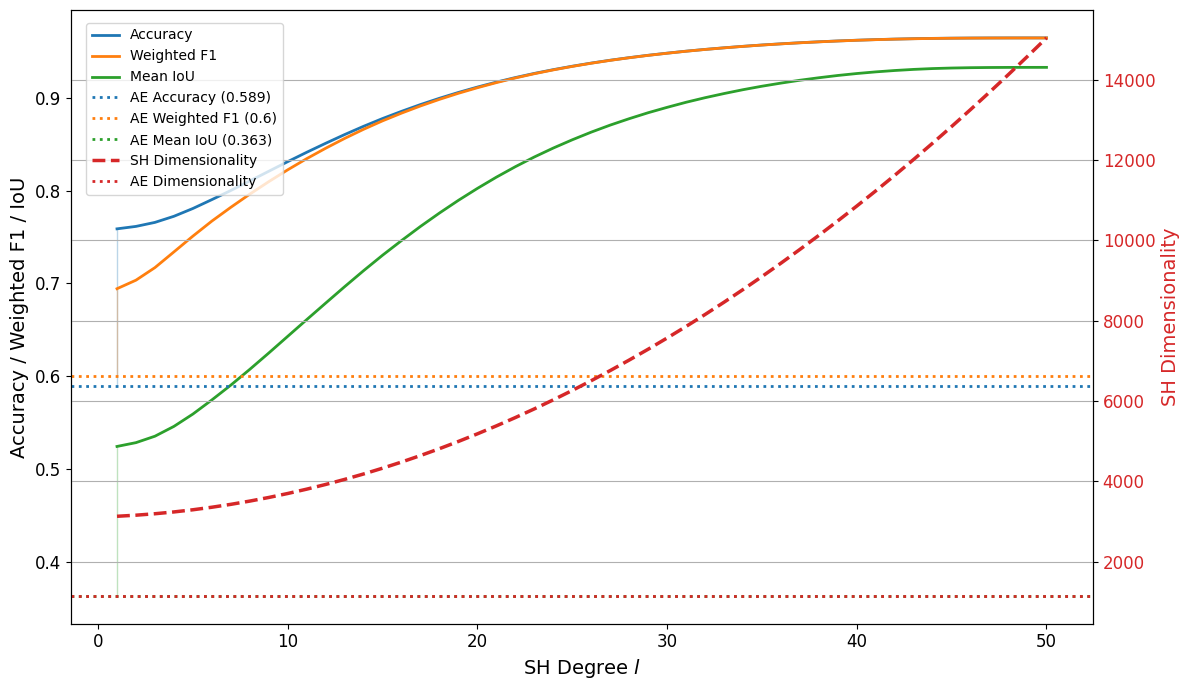

In [3]:
# ------------------- Re-import necessary libraries after kernel reset -------------------
import numpy as np
import healpy as hp
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

# ---------------- Metric Definitions ----------------
class CustomMeanIoU(tf.keras.metrics.Metric):
    def __init__(self, num_classes, name='custom_mean_iou', dtype=None, **kwargs):
        super(CustomMeanIoU, self).__init__(name=name, dtype=dtype, **kwargs)
        self.num_classes = num_classes
        self.total_cm = self.add_weight(
            name='total_confusion_matrix_var',
            shape=(num_classes, num_classes),
            initializer='zeros',
            dtype=tf.int64
        )

    def update_state(self, y_true, y_pred, sample_weight=None):
        predicted_labels = tf.argmax(y_pred, axis=-1)
        y_true = tf.cast(y_true, dtype=tf.int64)
        predicted_labels = tf.cast(predicted_labels, dtype=tf.int64)

        y_true_flat = tf.reshape(y_true, [-1])
        predicted_labels_flat = tf.reshape(predicted_labels, [-1])

        current_weights_flat = None
        if sample_weight is not None:
            current_weights_flat = tf.reshape(tf.cast(sample_weight, dtype=tf.float32), [-1])

        batch_cm = tf.math.confusion_matrix(
            labels=y_true_flat,
            predictions=predicted_labels_flat,
            num_classes=self.num_classes,
            weights=current_weights_flat,
            dtype=tf.int64
        )
        self.total_cm.assign_add(batch_cm)

    def result(self):
        sum_over_row = tf.cast(tf.reduce_sum(self.total_cm, axis=0), dtype=tf.float32)
        sum_over_col = tf.cast(tf.reduce_sum(self.total_cm, axis=1), dtype=tf.float32)
        true_positives = tf.cast(tf.linalg.diag_part(self.total_cm), dtype=tf.float32)

        denominator = sum_over_row + sum_over_col - true_positives
        iou_per_class = tf.math.divide_no_nan(true_positives, denominator)

        is_present = tf.cast(tf.math.not_equal(denominator, 0), dtype=tf.float32)
        num_present_classes = tf.reduce_sum(is_present)

        sum_iou_present_classes = tf.reduce_sum(iou_per_class * is_present)
        mean_iou = tf.math.divide_no_nan(sum_iou_present_classes, num_present_classes)
        return mean_iou

    def reset_state(self):
        self.total_cm.assign(tf.zeros(self.total_cm.shape, dtype=self.total_cm.dtype))

# ---------------- Evaluation Loop ----------------
nside = 16
lmax_values = np.arange(1, 51)
NSIDE = 16
N_PIX = hp.nside2npix(NSIDE)
n_samples = stacked.shape[0]
n_clusters = 3
LMAX_FOR_BACKGROUND = 44
BACKGROUND_RECON_THRESHOLD = 0.5
N_FOREGROUND_CLASSES = 3
N_TOTAL_CLASSES = 4
num_maps = 3

acc_values = []
f1_values = []
iou_values = []
dims_per_lmax = []

for lmax_fg in lmax_values:
    acc_total = 0.0
    f1_total = 0.0
    iou_metric = CustomMeanIoU(num_classes=4)

    for idx in range(n_samples):
        sample = stacked[idx]  # shape: (3072, 4)
        for ch in [1]:
            original_label_map = sample[:, ch].astype(np.int32)

            # 1. Reconstruct Background Channel (using LMAX_FOR_BACKGROUND)
            true_bg_channel_map = (original_label_map == 0).astype(float)
            alm_bg = hp.map2alm(true_bg_channel_map, lmax=LMAX_FOR_BACKGROUND)
            recon_bg_channel_raw = hp.alm2map(alm_bg, nside=nside, lmax=LMAX_FOR_BACKGROUND)
            predicted_is_background_mask = (recon_bg_channel_raw > BACKGROUND_RECON_THRESHOLD)

            # 2. Reconstruct Foreground Channels (using lmax_fg)
            onehot_fg_subtypes = np.stack([
                (original_label_map == c_label).astype(float) for c_label in range(1, N_FOREGROUND_CLASSES + 1)
            ], axis=-1)
            recon_fg_subtypes_raw_sh = np.zeros_like(onehot_fg_subtypes)
            for i in range(N_FOREGROUND_CLASSES):
                alm_fg = hp.map2alm(onehot_fg_subtypes[:, i], lmax=lmax_fg)
                recon_fg_subtypes_raw_sh[:, i] = hp.alm2map(alm_fg, nside=nside, lmax=lmax_fg)
            
            # 3. Determine Predicted Foreground Labels {1,2,3}
            predicted_fg_indices = np.argmax(recon_fg_subtypes_raw_sh, axis=-1)
            predicted_labels_foreground_only = predicted_fg_indices + 1

            # 4. Combine to get final predicted labels {0,1,2,3}
            y_pred_labels_np = predicted_labels_foreground_only.copy()
            y_pred_labels_np[predicted_is_background_mask] = 0

            y_true_labels_np = original_label_map
            
            acc_total += np.mean(y_pred_labels_np == y_true_labels_np)
            f1 = f1_score(y_true_labels_np, y_pred_labels_np, average='weighted', 
                        labels=list(range(N_TOTAL_CLASSES)), zero_division=0)
            f1_total += f1

            recon_logits_for_iou_np = np.full((N_PIX, N_TOTAL_CLASSES), -10.0, dtype=np.float32)
            recon_logits_for_iou_np[np.arange(N_PIX), y_pred_labels_np] = 0.0
            y_true_tf_iou = tf.convert_to_tensor(y_true_labels_np[None, ...], dtype=tf.int32)
            y_pred_tf_logits_iou = tf.convert_to_tensor(recon_logits_for_iou_np[None, ...], dtype=tf.float32)
            iou_metric.update_state(y_true_tf_iou, y_pred_tf_logits_iou)

    acc_values.append(acc_total / n_samples)
    f1_values.append(f1_total / n_samples)
    iou_values.append(iou_metric.result().numpy())
    dims_fg_per_channel = hp.Alm.getsize(lmax_fg)
    dims_bg_channel = hp.Alm.getsize(LMAX_FOR_BACKGROUND)
    dims_total = num_maps * (dims_bg_channel + (N_FOREGROUND_CLASSES * dims_fg_per_channel))
    dims_per_lmax.append(dims_total)

# Convert lists to numpy arrays if needed
lmax_array = np.array(lmax_values)
acc_array = np.array(acc_values)
f1_array = np.array(f1_values)
iou_array = np.array(iou_values)
dims_array = np.array(dims_per_lmax)

np.save('lmax_choice_final/phase_lmax_array.npy',   lmax_array)
np.save('lmax_choice_final/phase_accuracy.npy',     acc_array)
np.save('lmax_choice_final/phase_weighted_f1.npy',  f1_array)
np.save('lmax_choice_final/phase_mean_iou.npy',     iou_array)
np.save('lmax_choice_final/phase_dims.npy',         dims_array)


# ---------------- Baselines from Autoencoder ----------------
ae_acc = 0.589
ae_f1  = 0.600
ae_iou = 0.363
ae_dim = 1152

# ---------------- Find intersection point next biggest ----------------
dims_array_np = np.array(dims_array)
intersection_idx = np.argmin(np.abs(dims_array_np - ae_dim))
intersection_lmax = lmax_array[intersection_idx]

# ---------------- Plotting ----------------
fig, ax1 = plt.subplots(figsize=(12, 7))
ax1.set_xlabel('SH Degree $l$', fontsize=14)
ax1.set_ylabel('Accuracy / Weighted F1 / IoU', color='black', fontsize=14)
ax1.tick_params(axis='both', labelsize=12)

# Plot Accuracy, Weighted F1, and Mean IoU curves
line1, = ax1.plot(lmax_array, acc_array, label='Accuracy', color='tab:blue', linewidth=2)
line2, = ax1.plot(lmax_array, f1_array, label='Weighted F1', color='tab:orange', linewidth=2)
line3, = ax1.plot(lmax_array, iou_array, label='Mean IoU', color='tab:green', linewidth=2)

# AE baseline lines
line4 = ax1.axhline(ae_acc, color='tab:blue', linestyle=':', linewidth=2, label=f'AE Accuracy ({ae_acc})')
line5 = ax1.axhline(ae_f1,  color='tab:orange', linestyle=':', linewidth=2, label=f'AE Weighted F1 ({ae_f1})')
line6 = ax1.axhline(ae_iou, color='tab:green', linestyle=':', linewidth=2, label=f'AE Mean IoU ({ae_iou})')

# Shaded regions (only up to intersection index)
ax1.fill_between(
    lmax_array[:intersection_idx+1], acc_array[:intersection_idx+1], ae_acc,
    where=acc_array[:intersection_idx+1] > ae_acc,
    interpolate=True, color='tab:blue', alpha=0.3
)
ax1.fill_between(
    lmax_array[:intersection_idx+1], f1_array[:intersection_idx+1], ae_f1,
    where=f1_array[:intersection_idx+1] > ae_f1,
    interpolate=True, color='tab:orange', alpha=0.3
)
ax1.fill_between(
    lmax_array[:intersection_idx+1], iou_array[:intersection_idx+1], ae_iou,
    where=iou_array[:intersection_idx+1] > ae_iou,
    interpolate=True, color='tab:green', alpha=0.3
)

# Vertical intersection line
#line9 = ax1.axvline(
#    intersection_lmax,
#    color='gray',
#    linestyle='--',
##    linewidth=1.5,
#    label=f'SH = AE Dim at $l$={intersection_lmax}'
#)

ax1.tick_params(axis='y', labelcolor='black', labelsize=12)

# SH dimensionality axis
ax2 = ax1.twinx()
line7, = ax2.plot(lmax_array, dims_array, color='tab:red', linestyle='--', linewidth=2.5, label='SH Dimensionality')
line8 = ax2.axhline(ae_dim, color='tab:red', linestyle=':', linewidth=2, label='AE Dimensionality')
ax2.set_ylabel('SH Dimensionality', color='tab:red', fontsize=14)
ax2.tick_params(axis='y', labelcolor='tab:red', labelsize=12)

# Combine legends and place inside plot
lines = [line1, line2, line3, line4, line5, line6, line7, line8]
labels = [ln.get_label() for ln in lines]
fig.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.07, 0.97), fontsize=10)

plt.grid(True)
plt.tight_layout()
plt.savefig("lmax_choice_final/segmentation-sh-vs-ae_weightedF1.png", dpi=300)
plt.show()


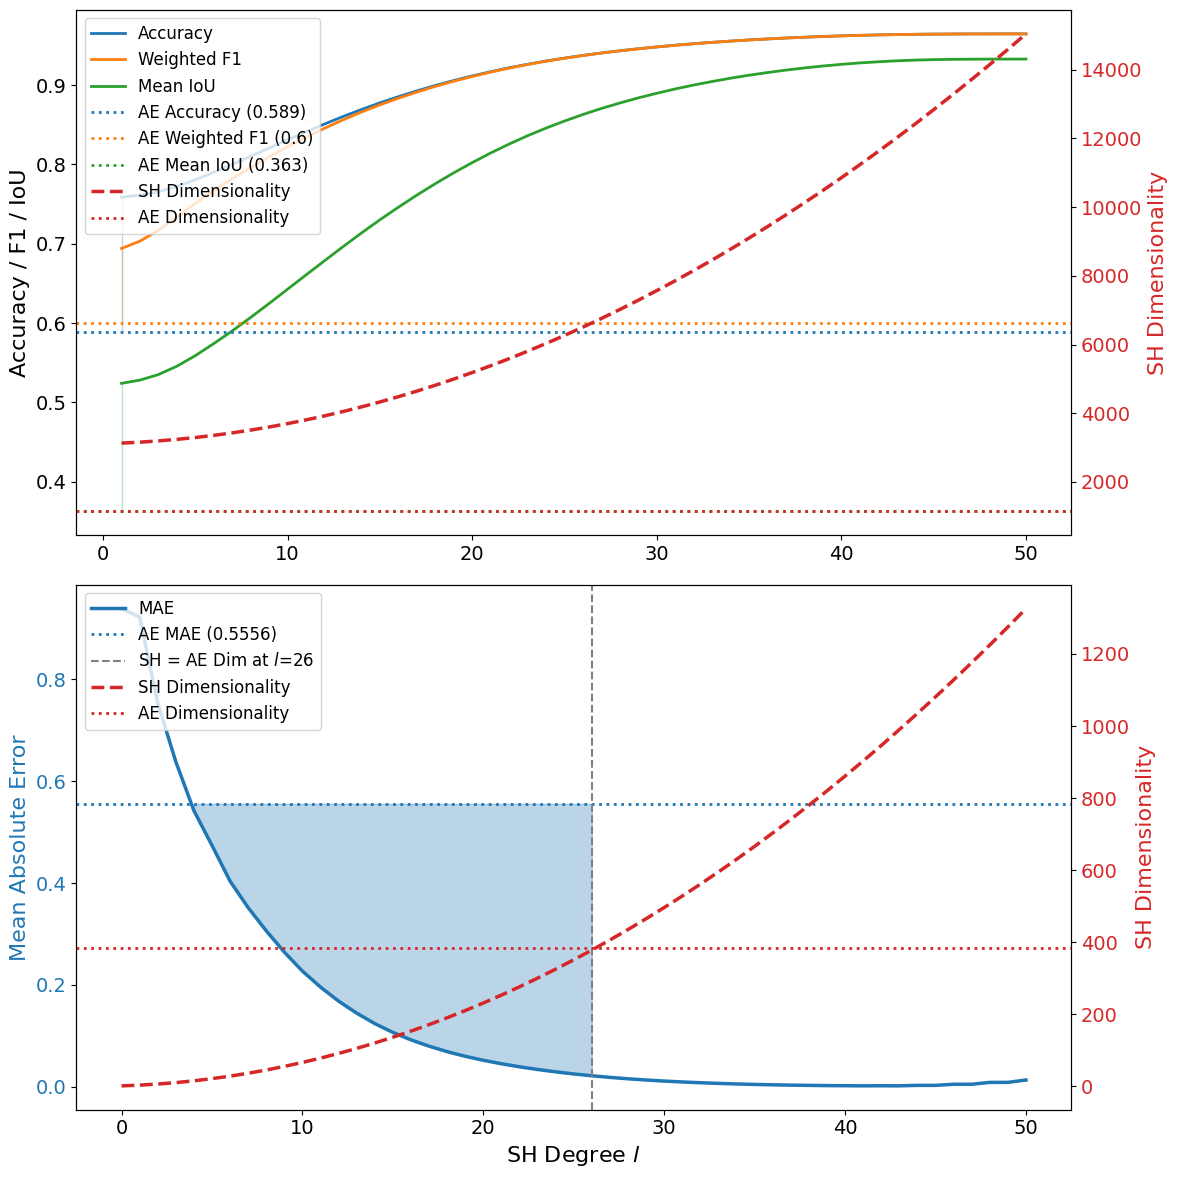

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os


# --- Load data for Phase (Segmentation) Plot ---
lmax_array = np.load("lmax_choice_final/phase_lmax_array.npy")
acc_array = np.load("lmax_choice_final/phase_accuracy.npy")
f1_array = np.load("lmax_choice_final/phase_weighted_f1.npy")
iou_array = np.load("lmax_choice_final/phase_mean_iou.npy")
phase_dims_array = np.load('lmax_choice_final/phase_dims.npy')
dims_array = phase_dims_array
# Autoencoder baselines for phase
ae_acc = 0.589
ae_f1 = 0.600
ae_iou = 0.363
ae_dim = 1152

used_lmax_values = np.load("lmax_choice_final/radial_used_lmax_values.npy")
mae_per_lmax = np.load("lmax_choice_final/radial_mae_per_lmax.npy")
radial_dims_array = np.load("lmax_choice_final/radial_dims_per_lmax.npy")
ae_mae = 0.5556
target_dim = 384




# Find SH = AE dimension intersection
intersection_idx_phase = np.argmin(np.abs(dims_array - ae_dim))
intersection_lmax_phase = lmax_array[intersection_idx_phase]


# Mask for l ≤ 50
mask_radial = used_lmax_values <= 50
l_vals_plot = used_lmax_values[mask_radial]
mae_plot = mae_per_lmax[mask_radial]
dims_plot = radial_dims_array

# Find intersections
idx_dim_mask = np.argmin(np.abs(dims_plot - target_dim))
idx_mae_mask = np.argmin(np.abs(mae_plot - ae_mae))
shade_start = min(idx_dim_mask, idx_mae_mask)
shade_end = max(idx_dim_mask, idx_mae_mask)
intersection_lmax_radial = l_vals_plot[idx_dim_mask]

# --- Create combined figure ---
plt.rcParams.update({
    "font.size": 14,
    "axes.titlesize": 15,
    "axes.labelsize": 16,
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "legend.fontsize": 12
})

fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# === Phase (Segmentation) Plot ===
ax2 = ax1.twinx()
ax1.plot(lmax_array, acc_array, label='Accuracy', color='tab:blue', linewidth=2)
ax1.plot(lmax_array, f1_array, label='Weighted F1', color='tab:orange', linewidth=2)
ax1.plot(lmax_array, iou_array, label='Mean IoU', color='tab:green', linewidth=2)


ax1.axhline(ae_acc, color='tab:blue', linestyle=':', linewidth=2, label=f'AE Accuracy ({ae_acc})')
ax1.axhline(ae_f1, color='tab:orange', linestyle=':', linewidth=2, label=f'AE Weighted F1 ({ae_f1})')
ax1.axhline(ae_iou, color='tab:green', linestyle=':', linewidth=2, label=f'AE Mean IoU ({ae_iou})')

ax1.fill_between(lmax_array[:intersection_idx_phase + 1], acc_array[:intersection_idx_phase + 1], ae_acc,
                 where=acc_array[:intersection_idx_phase + 1] > ae_acc, interpolate=True, color='tab:blue', alpha=0.3)
ax1.fill_between(lmax_array[:intersection_idx_phase + 1], f1_array[:intersection_idx_phase + 1], ae_f1,
                 where=f1_array[:intersection_idx_phase + 1] > ae_f1, interpolate=True, color='tab:orange', alpha=0.3)
ax1.fill_between(lmax_array[:intersection_idx_phase + 1], iou_array[:intersection_idx_phase + 1], ae_iou,
                 where=iou_array[:intersection_idx_phase + 1] > ae_iou, interpolate=True, color='tab:green', alpha=0.3)

ax1.axvline(intersection_lmax_phase, color='gray', linestyle='--', linewidth=1.5,
            label=f'SH = AE Dim at $l$={intersection_lmax_phase}')

ax2.plot(lmax_array, phase_dims_array, color='tab:red', linestyle='--', linewidth=2.5, label='SH Dimensionality')
ax2.axhline(ae_dim, color='tab:red', linestyle=':', linewidth=2, label='AE Dimensionality')
ax1.set_ylabel('Accuracy / F1 / IoU')
ax2.set_ylabel('SH Dimensionality', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

lines1 = ax1.get_lines() + ax2.get_lines()
labels1 = [line.get_label() for line in lines1]
ax1.legend(lines1, labels1, loc='upper left')
#ax1.set_title("Segmentation Performance vs SH Degree")

# === Radial MAE Plot ===
ax4 = ax3.twinx()
ax3.plot(l_vals_plot, mae_plot, label='MAE', color='tab:blue', linewidth=2.5)
ax3.axhline(ae_mae, color='tab:blue', linestyle=':', linewidth=2, label=f'AE MAE ({ae_mae})')
ax3.fill_between(l_vals_plot[shade_start:shade_end + 1], mae_plot[shade_start:shade_end + 1], ae_mae,
                 interpolate=True, color='tab:blue', alpha=0.3)
ax3.axvline(intersection_lmax_radial, color='gray', linestyle='--', linewidth=1.5,
            label=f'SH = AE Dim at $l$={intersection_lmax_radial}')

ax4.plot(l_vals_plot, dims_plot, color='tab:red', linestyle='--', linewidth=2.5, label='SH Dimensionality')
ax4.axhline(target_dim, color='tab:red', linestyle=':', linewidth=2, label='AE Dimensionality')
ax3.set_xlabel('SH Degree $l$')
ax3.set_ylabel('Mean Absolute Error', color='tab:blue')
ax3.tick_params(axis='y', labelcolor='tab:blue')
ax4.set_ylabel('SH Dimensionality', color='tab:red')
ax4.tick_params(axis='y', labelcolor='tab:red')

lines2 = ax3.get_lines() + ax4.get_lines()
labels2 = [line.get_label() for line in lines2]
ax3.legend(lines2, labels2, loc='upper left')
#ax3.set_title("Radial MAE vs SH Degree")

plt.tight_layout()
fig.savefig("lmax_choice_final/combined_sh_vs_ae_plots_corrected_dims.png", dpi=300, bbox_inches='tight')
plt.show()


In [7]:
used_lmax_values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [6]:
radial_dims_array

array([   1,    4,    9,   16,   25,   36,   49,   64,   81,  100,  121,
        144,  169,  196,  225,  256,  289,  324,  361,  400,  441,  484,
        529,  576,  625,  676,  729,  784,  841,  900,  961, 1024, 1089,
       1156, 1225, 1296, 1369, 1444, 1521, 1600, 1681, 1764, 1849, 1936,
       2025, 2116, 2209, 2304, 2401, 2500, 2601])

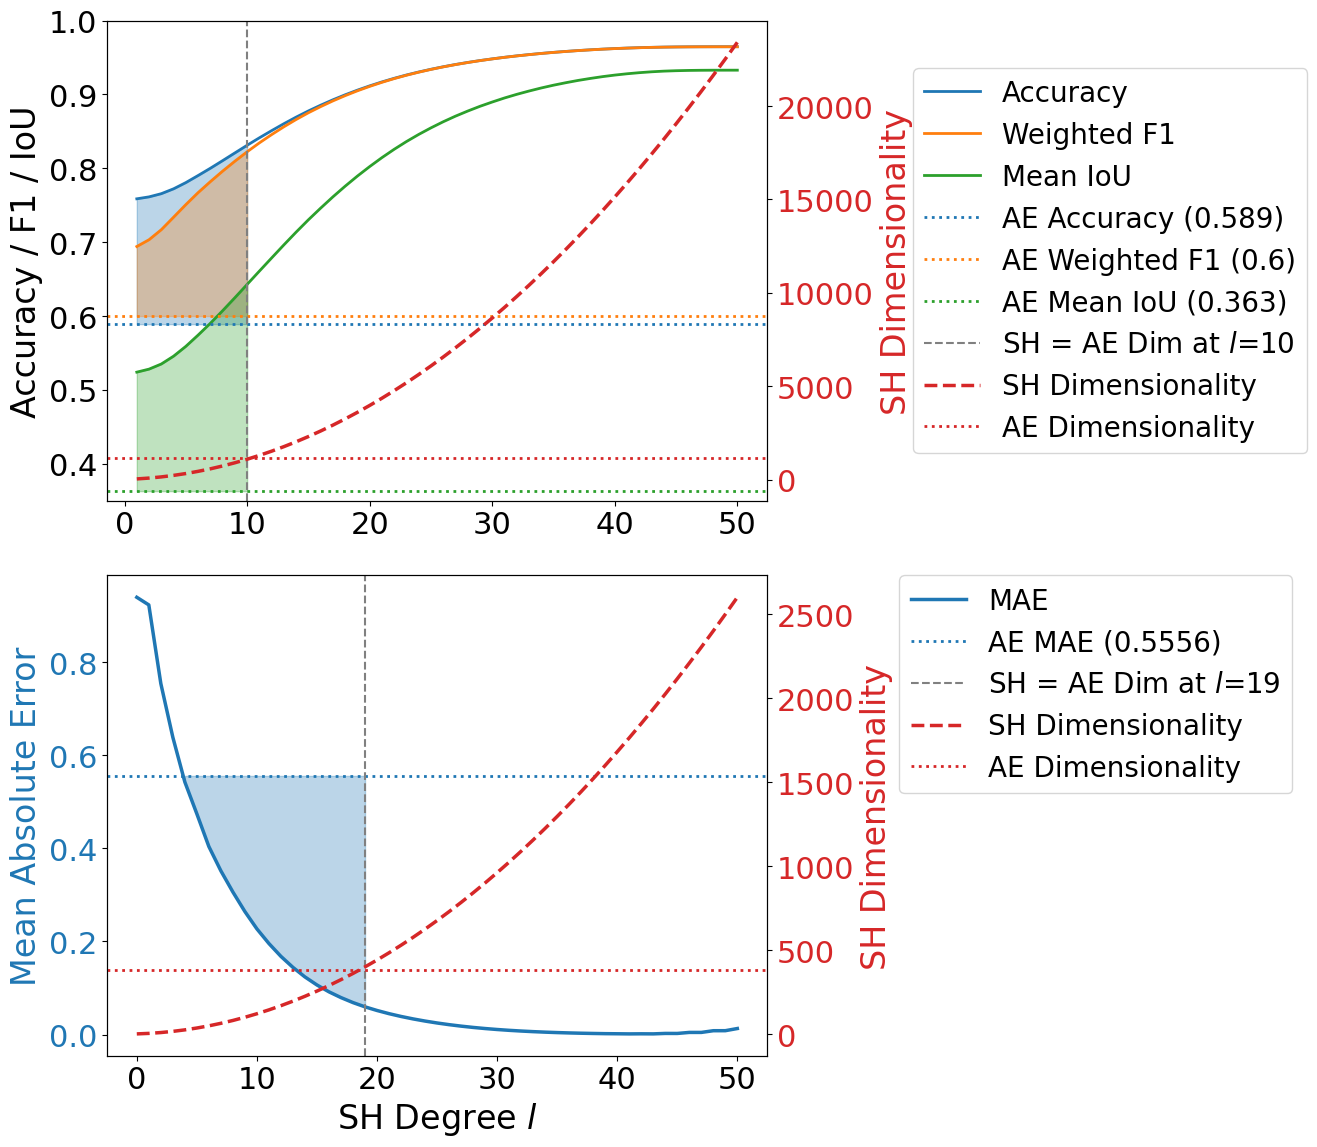

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Load data for Phase (Segmentation) Plot ---
lmax_array = np.load("lmax_choice_final/phase_lmax_array.npy")
acc_array = np.load("lmax_choice_final/phase_accuracy.npy")
f1_array = np.load("lmax_choice_final/phase_weighted_f1.npy")
iou_array = np.load("lmax_choice_final/phase_mean_iou.npy")

# Autoencoder baselines for phase
ae_acc = 0.589
ae_f1 = 0.600
ae_iou = 0.363
ae_dim = 1152

used_lmax_values = np.load("lmax_choice_final/radial_used_lmax_values.npy")
mae_per_lmax = np.load("lmax_choice_final/radial_mae_per_lmax.npy")
ae_mae = 0.5556
target_dim = 384

phase_dims_array = 3 * 3 * (lmax_array + 1) ** 2
dims_array = phase_dims_array
radial_dims_array = (used_lmax_values + 1) ** 2

# Find SH = AE dimension intersection
intersection_idx_phase = np.argmin(np.abs(dims_array - ae_dim))
intersection_lmax_phase = lmax_array[intersection_idx_phase]

# Mask for l ≤ 50
mask_radial = used_lmax_values <= 50
l_vals_plot = used_lmax_values[mask_radial]
mae_plot = mae_per_lmax[mask_radial]
dims_plot = radial_dims_array[mask_radial]  # Corrected here

# Find intersections
idx_dim_mask = np.argmin(np.abs(dims_plot - target_dim))
idx_mae_mask = np.argmin(np.abs(mae_plot - ae_mae))
shade_start = min(idx_dim_mask, idx_mae_mask)
shade_end = max(idx_dim_mask, idx_mae_mask)
intersection_lmax_radial = l_vals_plot[idx_dim_mask]

# --- Create combined figure ---
plt.rcParams.update({
    "font.size": 24,
    "axes.titlesize": 24,
    "axes.labelsize": 24,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 22
})

fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 12), sharex=False)

# === Phase (Segmentation) Plot ===
ax2 = ax1.twinx()
ax1.plot(lmax_array, acc_array, label='Accuracy', color='tab:blue', linewidth=2)
ax1.plot(lmax_array, f1_array, label='Weighted F1', color='tab:orange', linewidth=2)
ax1.plot(lmax_array, iou_array, label='Mean IoU', color='tab:green', linewidth=2)

ax1.axhline(ae_acc, color='tab:blue', linestyle=':', linewidth=2, label=f'AE Accuracy ({ae_acc})')
ax1.axhline(ae_f1, color='tab:orange', linestyle=':', linewidth=2, label=f'AE Weighted F1 ({ae_f1})')
ax1.axhline(ae_iou, color='tab:green', linestyle=':', linewidth=2, label=f'AE Mean IoU ({ae_iou})')

ax1.axvline(intersection_lmax_phase, color='gray', linestyle='--', linewidth=1.5,
            label=f'SH = AE Dim at $l$={intersection_lmax_phase}')

# Shaded regions up to intersection index
ax1.fill_between(
    lmax_array[:intersection_idx_phase + 1], acc_array[:intersection_idx_phase + 1], ae_acc,
    where=acc_array[:intersection_idx_phase + 1] > ae_acc,
    interpolate=True, color='tab:blue', alpha=0.3
)
ax1.fill_between(
    lmax_array[:intersection_idx_phase + 1], f1_array[:intersection_idx_phase + 1], ae_f1,
    where=f1_array[:intersection_idx_phase + 1] > ae_f1,
    interpolate=True, color='tab:orange', alpha=0.3
)
ax1.fill_between(
    lmax_array[:intersection_idx_phase + 1], iou_array[:intersection_idx_phase + 1], ae_iou,
    where=iou_array[:intersection_idx_phase + 1] > ae_iou,
    interpolate=True, color='tab:green', alpha=0.3
)

ax2.plot(lmax_array, phase_dims_array, color='tab:red', linestyle='--', linewidth=2.5, label='SH Dimensionality')
ax2.axhline(ae_dim, color='tab:red', linestyle=':', linewidth=2, label='AE Dimensionality')

ax1.set_ylabel('Accuracy / F1 / IoU')
ax1.set_ylim(0.35, 1.0)
ax2.set_ylabel('SH Dimensionality', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

lines1 = ax1.get_lines() + ax2.get_lines()
labels1 = [line.get_label() for line in lines1]
#ax1.legend(lines1, labels1, loc='upper right', bbox_to_anchor=(2, -0.015))
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])  # shrink width to 80%
ax1.legend(
    lines1,
    labels1,
    loc="center left",
    bbox_to_anchor=(1.2, 0.5),
    fontsize="small"
)


# === Radial MAE Plot ===
ax4 = ax3.twinx()
ax3.plot(l_vals_plot, mae_plot, label='MAE', color='tab:blue', linewidth=2.5)
ax3.axhline(ae_mae, color='tab:blue', linestyle=':', linewidth=2, label=f'AE MAE ({ae_mae})')
ax3.fill_between(l_vals_plot[shade_start:shade_end + 1], mae_plot[shade_start:shade_end + 1], ae_mae,
                 interpolate=True, color='tab:blue', alpha=0.3)
ax3.axvline(intersection_lmax_radial, color='gray', linestyle='--', linewidth=1.5,
            label=f'SH = AE Dim at $l$={intersection_lmax_radial}')

ax4.plot(l_vals_plot, dims_plot, color='tab:red', linestyle='--', linewidth=2.5, label='SH Dimensionality')
ax4.axhline(target_dim, color='tab:red', linestyle=':', linewidth=2, label='AE Dimensionality')
ax3.set_xlabel('SH Degree $l$')
ax3.set_ylabel('Mean Absolute Error', color='tab:blue')
ax3.tick_params(axis='y', labelcolor='tab:blue')
ax4.set_ylabel('SH Dimensionality', color='tab:red')
ax4.tick_params(axis='y', labelcolor='tab:red')

lines2 = ax3.get_lines() + ax4.get_lines()
labels2 = [line.get_label() for line in lines2]
#ax3.legend(lines2, labels2, loc='upper left')
# Shrink axis width to make space
box2 = ax3.get_position()
ax3.set_position([box2.x0, box2.y0, box2.width * 0.8, box2.height])  # Adjust width only

# Place legend just outside the right edge, vertically aligned with top
ax3.legend(
    lines2,
    labels2,
    loc="upper left",               # aligns upper left corner of legend
    bbox_to_anchor=(1.2, 1),       # just outside right edge of ax2
    bbox_transform=ax3.transAxes,  # << this ensures it's relative to ax2!
    borderaxespad=0,
    fontsize="small"
)

plt.tight_layout()
fig.savefig("lmax_choice_final/combined_sh_vs_ae_plots_corrected_dims-final-larger.png", dpi=300, bbox_inches='tight')
plt.show()


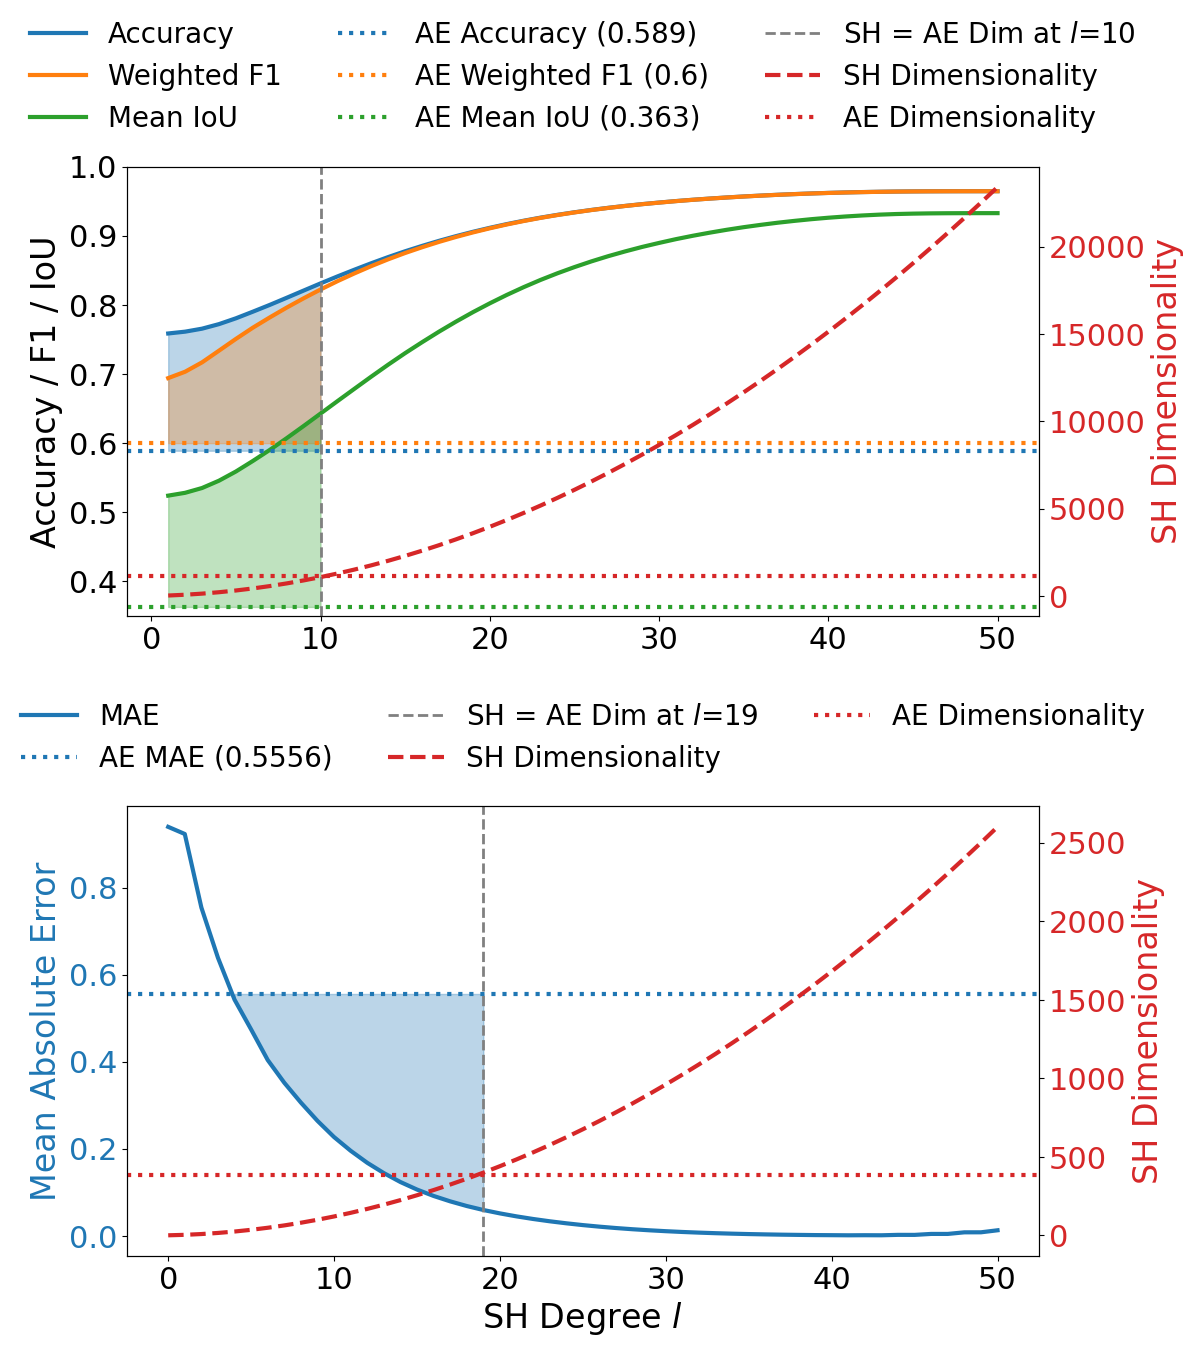

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Load data for Phase (Segmentation) Plot ---
lmax_array = np.load("lmax_choice_final/phase_lmax_array.npy")
acc_array = np.load("lmax_choice_final/phase_accuracy.npy")
f1_array = np.load("lmax_choice_final/phase_weighted_f1.npy")
iou_array = np.load("lmax_choice_final/phase_mean_iou.npy")

# Autoencoder baselines for phase
ae_acc = 0.589
ae_f1 = 0.600
ae_iou = 0.363
ae_dim = 1152

used_lmax_values = np.load("lmax_choice_final/radial_used_lmax_values.npy")
mae_per_lmax = np.load("lmax_choice_final/radial_mae_per_lmax.npy")
ae_mae = 0.5556
target_dim = 384

phase_dims_array = 3 * 3 * (lmax_array + 1) ** 2
dims_array = phase_dims_array
radial_dims_array = (used_lmax_values + 1) ** 2

# Find SH = AE dimension intersection
intersection_idx_phase = np.argmin(np.abs(dims_array - ae_dim))
intersection_lmax_phase = lmax_array[intersection_idx_phase]

# Mask for l ≤ 50
mask_radial = used_lmax_values <= 50
l_vals_plot = used_lmax_values[mask_radial]
mae_plot = mae_per_lmax[mask_radial]
dims_plot = radial_dims_array[mask_radial]  # Corrected here

# Find intersections
idx_dim_mask = np.argmin(np.abs(dims_plot - target_dim))
idx_mae_mask = np.argmin(np.abs(mae_plot - ae_mae))
shade_start = min(idx_dim_mask, idx_mae_mask)
shade_end = max(idx_dim_mask, idx_mae_mask)
intersection_lmax_radial = l_vals_plot[idx_dim_mask]

# --- Create combined figure ---
plt.rcParams.update({
    "font.size": 24,
    "axes.titlesize": 24,
    "axes.labelsize": 24,
    "xtick.labelsize": 22,
    "ytick.labelsize": 22,
    "legend.fontsize": 22
})

fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(12, 14), sharex=False)

# === Phase (Segmentation) Plot ===
ax2 = ax1.twinx()
ax1.plot(lmax_array, acc_array, label='Accuracy', color='tab:blue', linewidth=3)
ax1.plot(lmax_array, f1_array, label='Weighted F1', color='tab:orange', linewidth=3)
ax1.plot(lmax_array, iou_array, label='Mean IoU', color='tab:green', linewidth=3)

ax1.axhline(ae_acc, color='tab:blue', linestyle=':', linewidth=3, label=f'AE Accuracy ({ae_acc})')
ax1.axhline(ae_f1, color='tab:orange', linestyle=':', linewidth=3, label=f'AE Weighted F1 ({ae_f1})')
ax1.axhline(ae_iou, color='tab:green', linestyle=':', linewidth=3, label=f'AE Mean IoU ({ae_iou})')

ax1.axvline(intersection_lmax_phase, color='gray', linestyle='--', linewidth=2,
            label=f'SH = AE Dim at $l$={intersection_lmax_phase}')

# Shaded regions up to intersection index
ax1.fill_between(
    lmax_array[:intersection_idx_phase + 1], acc_array[:intersection_idx_phase + 1], ae_acc,
    where=acc_array[:intersection_idx_phase + 1] > ae_acc,
    interpolate=True, color='tab:blue', alpha=0.3
)
ax1.fill_between(
    lmax_array[:intersection_idx_phase + 1], f1_array[:intersection_idx_phase + 1], ae_f1,
    where=f1_array[:intersection_idx_phase + 1] > ae_f1,
    interpolate=True, color='tab:orange', alpha=0.3
)
ax1.fill_between(
    lmax_array[:intersection_idx_phase + 1], iou_array[:intersection_idx_phase + 1], ae_iou,
    where=iou_array[:intersection_idx_phase + 1] > ae_iou,
    interpolate=True, color='tab:green', alpha=0.3
)

ax2.plot(lmax_array, phase_dims_array, color='tab:red', linestyle='--', linewidth=3, label='SH Dimensionality')
ax2.axhline(ae_dim, color='tab:red', linestyle=':', linewidth=3, label='AE Dimensionality')

ax1.set_ylabel('Accuracy / F1 / IoU')
ax1.set_ylim(0.35, 1.0)
ax2.set_ylabel('SH Dimensionality', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

lines1 = ax1.get_lines() + ax2.get_lines()
labels1 = [line.get_label() for line in lines1]
#ax1.legend(lines1, labels1, loc='upper right', bbox_to_anchor=(2, -0.015))
box = ax1.get_position()
ax1.set_position([box.x0, box.y0, box.width * 0.8, box.height])  # shrink width to 80%
ax1.legend(
    lines1,
    labels1,
    loc='lower center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=3,
    fontsize='small',
    frameon=False
)


# === Radial MAE Plot ===
ax4 = ax3.twinx()
ax3.plot(l_vals_plot, mae_plot, label='MAE', color='tab:blue', linewidth=3)
ax3.axhline(ae_mae, color='tab:blue', linestyle=':', linewidth=3, label=f'AE MAE ({ae_mae})')
ax3.fill_between(l_vals_plot[shade_start:shade_end + 1], mae_plot[shade_start:shade_end + 1], ae_mae,
                 interpolate=True, color='tab:blue', alpha=0.3)
ax3.axvline(intersection_lmax_radial, color='gray', linestyle='--', linewidth=2,
            label=f'SH = AE Dim at $l$={intersection_lmax_radial}')

ax4.plot(l_vals_plot, dims_plot, color='tab:red', linestyle='--', linewidth=3, label='SH Dimensionality')
ax4.axhline(target_dim, color='tab:red', linestyle=':', linewidth=3, label='AE Dimensionality')
ax3.set_xlabel('SH Degree $l$')
ax3.set_ylabel('Mean Absolute Error', color='tab:blue')
ax3.tick_params(axis='y', labelcolor='tab:blue')
ax4.set_ylabel('SH Dimensionality', color='tab:red')
ax4.tick_params(axis='y', labelcolor='tab:red')

lines2 = ax3.get_lines() + ax4.get_lines()
labels2 = [line.get_label() for line in lines2]
#ax3.legend(lines2, labels2, loc='upper left')
# Shrink axis width to make space
box2 = ax3.get_position()
ax3.set_position([box2.x0, box2.y0, box2.width * 0.8, box2.height])  # Adjust width only

# Place legend just outside the right edge, vertically aligned with top
ax3.legend(
    lines2,
    labels2,
    loc='lower center',
    bbox_to_anchor=(0.5, 1.02),
    ncol=3,
    fontsize='small',
    frameon=False
)


plt.tight_layout()
fig.savefig("lmax_choice_final/combined_sh_vs_ae_plots_corrected_dims-final-larger.png", dpi=300, bbox_inches='tight')
plt.show()
